In this analysis, I am are exploring the users_behavior dataset to understand user interactions with a communication service. The Mobile carrier Megaline has found out that many of their subscribers use legacy plans and my goal is to develop a model that will analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.  I will begin by loading the data and verifying the data types of key columns, converting the columns as needed. I will then visualize the distributions of calls, minutes, messages, and MB used through visual aids, which will help me identify patterns and trends.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score  # Import accuracy_score






# Use the raw URL from github file uploaded to read the CSV file
url = 'https://raw.githubusercontent.com/Emily-Ebaugh/users_behavior.csv/refs/heads/main/users_behavior.csv'
users_behavior = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(users_behavior.head())

   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0


In [16]:
print(users_behavior.dtypes) 

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object


In [17]:
# Convert columns to int64 if they should only contain whole numbers
users_behavior['calls'] = users_behavior['calls'].astype('int64')
users_behavior['messages'] = users_behavior['messages'].astype('int64')

# Verify the changes
print(users_behavior.dtypes)

calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object


In [18]:
print(users_behavior.describe())  # Summary statistics for numerical columns

             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000


In [19]:
print(users_behavior.isnull().sum())  # Count of missing values in each column

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


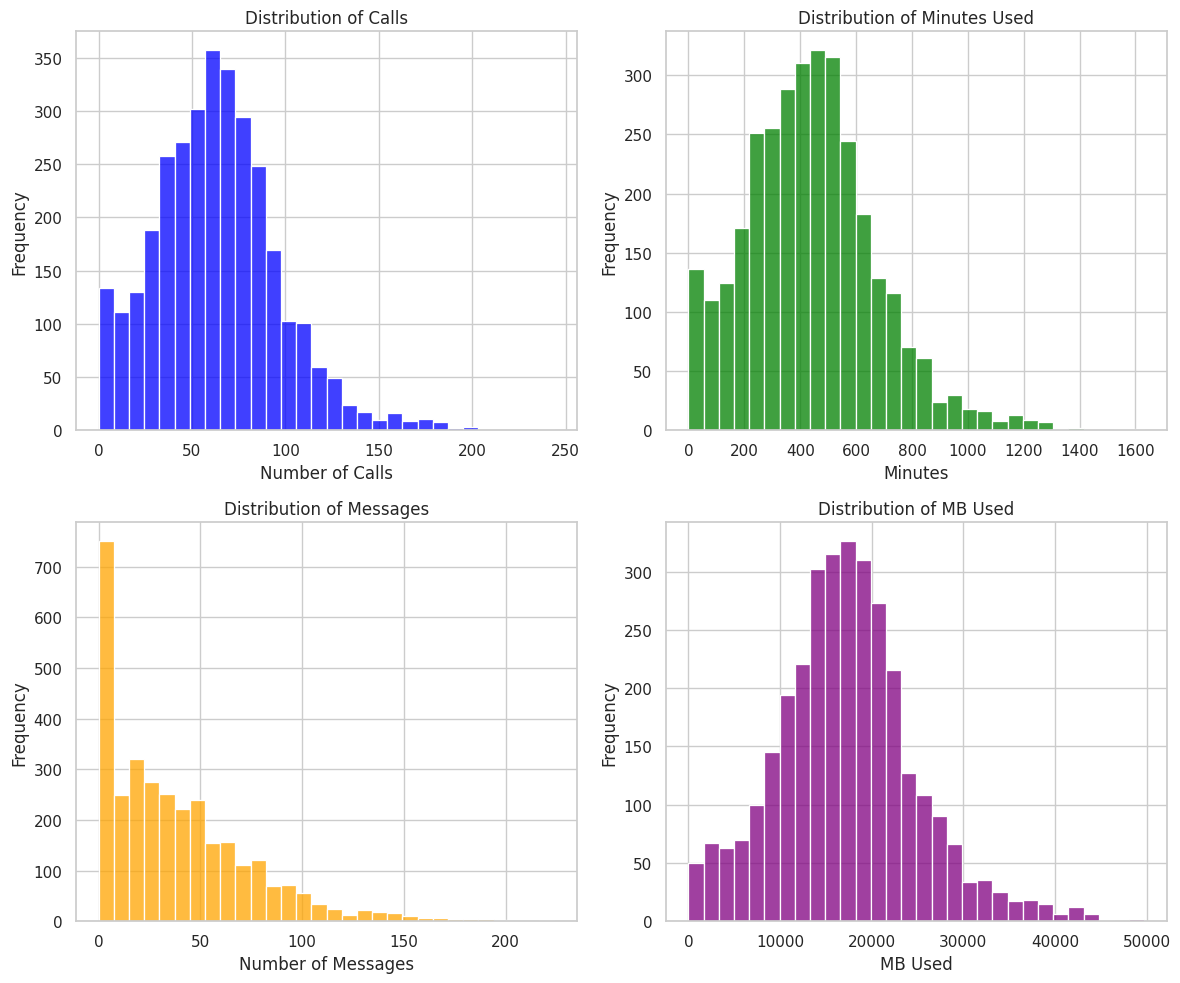

In [20]:


# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for each column
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for 'calls'
sns.histplot(users_behavior['calls'], bins=30, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Distribution of Calls')
axes[0, 0].set_xlabel('Number of Calls')
axes[0, 0].set_ylabel('Frequency')

# Histogram for 'minutes'
sns.histplot(users_behavior['minutes'], bins=30, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Distribution of Minutes Used')
axes[0, 1].set_xlabel('Minutes')
axes[0, 1].set_ylabel('Frequency')

# Histogram for 'messages'
sns.histplot(users_behavior['messages'], bins=30, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Distribution of Messages')
axes[1, 0].set_xlabel('Number of Messages')
axes[1, 0].set_ylabel('Frequency')

# Histogram for 'mb_used'
sns.histplot(users_behavior['mb_used'], bins=30, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Distribution of MB Used')
axes[1, 1].set_xlabel('MB Used')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

After seeing the graphs, I would like to visualize the relationships between calls and minutes used, as well as messages and MB used, using scatter plots to assess potential correlations:

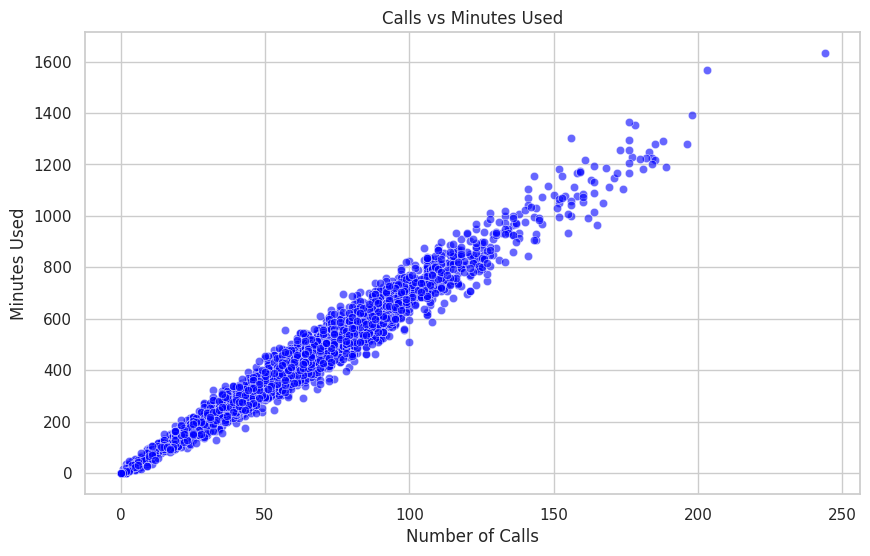

In [21]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a scatter plot for 'calls' vs 'minutes'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=users_behavior, x='calls', y='minutes', color='blue', alpha=0.6)
plt.title('Calls vs Minutes Used')
plt.xlabel('Number of Calls')
plt.ylabel('Minutes Used')
plt.grid(True)
plt.show()

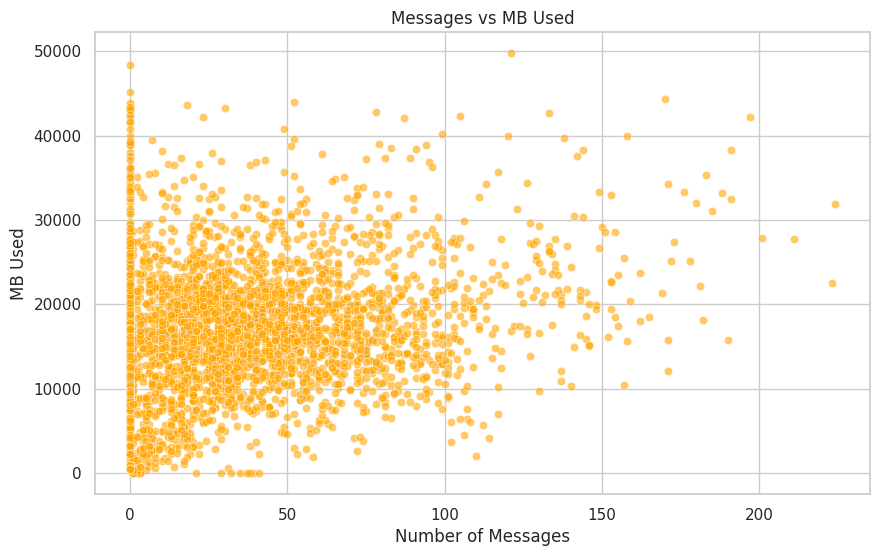

In [22]:
# Create a scatter plot for 'messages' vs 'mb_used'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=users_behavior, x='messages', y='mb_used', color='orange', alpha=0.6)
plt.title('Messages vs MB Used')
plt.xlabel('Number of Messages')
plt.ylabel('MB Used')
plt.grid(True)
plt.show()

Next, I will split the source data into a training set, a validation set, and a test set.

In [23]:

# Split the data into training and temp (validation + test) sets
train_set, temp_set = train_test_split(users_behavior, test_size=0.3, random_state=42)

# Split the temp set into validation and test sets
validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Display the sizes of each set
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 2249
Validation set size: 482
Test set size: 483


Now I will investigate the quality of different models to see which fits best:

In [24]:
# Sample a fraction of the training set for quicker testing
train_set_sample = train_set.sample(frac=0.1, random_state=42)

# Prepare features and target variable
X_train = train_set_sample.drop('is_ultra', axis=1)
y_train = train_set_sample['is_ultra']
X_val = validation_set.drop('is_ultra', axis=1)
y_val = validation_set['is_ultra']
X_test = test_set.drop('is_ultra', axis=1)
y_test = test_set['is_ultra']

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    "Logistic Regression": LogisticRegression(solver='liblinear')  # Use 'liblinear' for binary classification
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    print(f"{model_name} Validation Set Performance:")
    print(classification_report(y_val, val_predictions))

    test_predictions = model.predict(X_test)
    print(f"{model_name} Test Set Performance:")
    print(classification_report(y_test, test_predictions))

Decision Tree Validation Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       341
           1       0.44      0.48      0.46       141

    accuracy                           0.67       482
   macro avg       0.61      0.61      0.61       482
weighted avg       0.68      0.67      0.67       482

Decision Tree Test Set Performance:
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       319
           1       0.44      0.52      0.48       164

    accuracy                           0.61       483
   macro avg       0.59      0.59      0.59       483
weighted avg       0.63      0.61      0.62       483

Random Forest Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       341
           1       0.65      0.52      0.58       141

    accuracy                           0.78       482
   macro

In [25]:
# Define the model with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define a smaller hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)

# Fit the model
print("Starting Randomized Search...")
random_search.fit(train_set.drop('is_ultra', axis=1), train_set['is_ultra'])
print("Randomized Search Completed.")

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate on the validation set
val_predictions = best_model.predict(validation_set.drop('is_ultra', axis=1))
print("Validation Set Performance:")
print(classification_report(validation_set['is_ultra'], val_predictions))

# Evaluate on the test set
test_predictions = best_model.predict(test_set.drop('is_ultra', axis=1))
print("Test Set Performance:")
print(classification_report(test_set['is_ultra'], test_predictions))

Starting Randomized Search...
Randomized Search Completed.
Validation Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       341
           1       0.76      0.56      0.64       141

    accuracy                           0.82       482
   macro avg       0.80      0.74      0.76       482
weighted avg       0.81      0.82      0.81       482

Test Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       319
           1       0.78      0.55      0.64       164

    accuracy                           0.79       483
   macro avg       0.79      0.73      0.75       483
weighted avg       0.79      0.79      0.78       483



In [26]:
# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(train_set.drop('is_ultra', axis=1), train_set['is_ultra'])

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the validation set
val_predictions = best_model.predict(validation_set.drop('is_ultra', axis=1))
print("Validation Set Performance:")
print(classification_report(validation_set['is_ultra'], val_predictions))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       341
           1       0.80      0.54      0.64       141

    accuracy                           0.83       482
   macro avg       0.82      0.74      0.76       482
weighted avg       0.82      0.83      0.81       482



Random Forest has proven to be the superior choice with an accuracy reaching 83%. This had been proven when I checked the quality of the model using the test set above. Next, I am going to do a sanity check on the model.

In [27]:
# Assuming you have the training predictions
train_predictions = best_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"Training Set Accuracy: {train_accuracy:.2f}")

Training Set Accuracy: 0.82


In [28]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, train_set.drop('is_ultra', axis=1), train_set['is_ultra'], cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.82       0.81555556 0.81333333 0.82444444 0.78619154]
Mean CV Score: 0.81


In this project, I developed a predictive model to analyze subscriber behavior for Megaline, aiming to recommend either the Smart or Ultra plan. The Random Forest classifier achieved a training accuracy of 82% and a mean cross-validation score of 82%, indicating strong performance in predicting subscriber preferences. By examining usage patterns and feature importance, I identified that the Ultra plan is suitable for high-data users seeking premium features, while the Smart plan appeals to cost-sensitive subscribers. A targeted marketing approach based on these insights will enhance customer engagement and facilitate smoother transitions from legacy plans. Overall, leveraging the model's recommendations will enable Megaline to optimize its offerings and better meet subscriber needs.